In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/stat_project/analysis')

In [3]:
%cd /content/drive/MyDrive/stat_project/analysis

/content/drive/MyDrive/stat_project/analysis


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error , mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf




#preprocessing data

In [5]:
# Path to stock data CSV file
file_path = '/content/drive/MyDrive/stat_project/analysis/trainingset/FPT_stock_data.csv'
sentiment_file_path = '/content/drive/MyDrive/stat_project/analysis/trainingset/FPT_articles_data.csv'
data = pd.read_csv(file_path)


# Convert 'date' column to datetime format and handle any parsing errors
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y', errors='coerce')

# Drop rows with failed 'date' conversion (i.e., NaT values)
data = data.dropna(subset=['date'])

# Sort data by 'date' in ascending order
data = data.sort_values(by='date')

# Reset the index for better readability
data.reset_index(drop=True, inplace=True)

# Keep only 'date' and 'close_price' columns
data = data[['date', 'close_price']]

# Set 'date' as the index
data.set_index('date', inplace=True)

data = data[~data.index.duplicated(keep='first')]

# Create daily frequency and interpolate missing values
data = data.asfreq('D')
data['close_price'] = data['close_price'].interpolate()


# --- Filter data based on date range ---
# Input the start and end date
train_start_date = '2024-03-27'
train_end_date = '2024-11-01'
forecast_start_date = '2024-11-02'
forecast_end_date = '2024-12-31'

# Filter the data based on the given date range
filtered_data = data.loc[train_start_date:train_end_date]
filtered_data = filtered_data.asfreq('D')  # Set daily frequency
filtered_data['close_price'] = filtered_data['close_price'].interpolate()  # Interpolate missing values


# Future data
future_data = data.loc[forecast_start_date:forecast_end_date]

# --- Integrate sentiment data ---
# Path to sentiment data CSV file
df_articles = pd.read_csv(sentiment_file_path)

df_articles['Date posted'] = df_articles['Date posted'].str.strip()
df_articles['Date posted'] = df_articles['Date posted'].str.replace(r'[^\w\s/-]', '', regex=True)

# Convert 'Date' column in sentiment data to datetime format
df_articles['Date'] = pd.to_datetime(df_articles['Date posted'], dayfirst=True, errors='coerce')

# Drop rows with failed 'Date' conversion
df_articles = df_articles.dropna(subset=['Date'])
df_articles = df_articles.sort_values(by='Date')
df_articles.set_index('Date', inplace=True)
# Normalize sentiment scores from 1-10 to -1 to 1
df_articles.loc[:, 'Normalized_Sentiment'] = (df_articles['Emotional Rating (1-10)'] - 5.5) / 4.5

# --- Combine data ---
# Merge sentiment data into filtered stock data on 'Date'
df_combined = filtered_data.join(df_articles[['Normalized_Sentiment']], how='left')
df_combined = df_combined.asfreq('D')

# Fill missing sentiment values (if necessary)
df_combined['close_price'] = df_combined['close_price'].interpolate()
df_combined['Normalized_Sentiment'] = df_combined['Normalized_Sentiment'].interpolate()

# Prepare exogenous data for the future
## Give last value of exog into the training set
last_exog_value = df_combined.loc[train_start_date:train_end_date, 'Normalized_Sentiment'].iloc[-1]
future_sentiment = df_articles[['Normalized_Sentiment']].loc[forecast_start_date:forecast_end_date]
future_sentiment = future_sentiment.reindex(pd.date_range(start='2024-11-02', end=forecast_end_date, freq='D'))
# Fill missing values before the days with exogenous data using the last known value from the training set
future_sentiment['Normalized_Sentiment'] = future_sentiment['Normalized_Sentiment'].fillna(last_exog_value)
# Interpolate if necessary (in case of gaps between days)
future_sentiment['Normalized_Sentiment'] = future_sentiment['Normalized_Sentiment'].interpolate(method='linear')
# Fill missing values after the last known day with the last known value
future_sentiment['Normalized_Sentiment'] = future_sentiment['Normalized_Sentiment'].ffill()

# Save processed data
df_combined.to_csv('/content/drive/MyDrive/stat_project/analysis/trainingset/combined_data.csv')
future_sentiment.to_csv('/content/drive/MyDrive/stat_project/analysis/trainingset/future_sentiment_data.csv')
# Print sample data
print("Training and test data:")
print(df_combined.head())
print("\nFuture exogenous data:")
print(future_sentiment.head())


Training and test data:
            close_price  Normalized_Sentiment
date                                         
2024-03-27        115.2              0.555556
2024-03-28        117.1              0.553216
2024-03-29        116.5              0.550877
2024-03-30        116.6              0.548538
2024-03-31        116.7              0.546199

Future exogenous data:
            Normalized_Sentiment
2024-11-02              0.555556
2024-11-03              0.555556
2024-11-04              0.555556
2024-11-05              0.333333
2024-11-06              0.555556


#Arimax

Phân tích ACF:
Biểu đồ ACF cho thấy các giá trị tự tương quan giảm dần một cách chậm rãi, đây là dấu hiệu của việc dữ liệu có thể không dừng và có xu hướng (trend).
Điều này gợi ý rằng cần bậc tích phân d > 0 để làm cho chuỗi dữ liệu dừng lại.

Phân tích PACF:
Biểu đồ PACF cho thấy một vài giá trị lớn ở độ trễ ban đầu (lag 1), sau đó nhanh chóng giảm xuống gần 0. Điều này có thể gợi ý rằng nên chọn bậc p = 1 cho phần tự hồi quy (AR).
Các giá trị tiếp theo hầu hết nằm trong khoảng tin cậy, cho thấy không cần thêm nhiều bậc trong phần AR.

Đề xuất các tham số (p, d, q):
p = 1: Vì biểu đồ PACF chỉ có một giá trị vượt quá ngưỡng đáng kể ở độ trễ đầu tiên.
d = 1: Do biểu đồ ACF giảm dần chậm, cho thấy dữ liệu không dừng và cần tích phân một lần để làm dừng.
q = 0 hoặc 1: Biểu đồ ACF không cho thấy bất kỳ giá trị nổi bật nào sau lag đầu tiên, vì vậy q có thể bắt đầu từ 0 và tăng dần nếu cần thiết.

#---------------------------------#

ACF Analysis: The ACF plot shows that the autocorrelation values decrease slowly, which is a sign that the data might not be stationary and may exhibit a trend. This suggests that a differencing order d > 0 may be needed to make the time series stationary.

PACF Analysis: The PACF plot shows a few large values at the initial lags (lag 1), which then quickly decrease to near zero. This may suggest that p = 1 should be chosen for the autoregressive (AR) part. The subsequent values mostly lie within the confidence interval, indicating that no further lags are needed in the AR part.

Proposed parameters (p, d, q):

p = 1: Since the PACF plot shows only one significant value at the first lag.
d = 1: Because the ACF plot decreases slowly, suggesting the data is non-stationary and requires one differencing to become stationary.
q = 0 or 1: The ACF plot does not show any significant values after the first lag, so q can start at 0 and be increased if necessary.

220
The maximum number of lags allowed is: 110


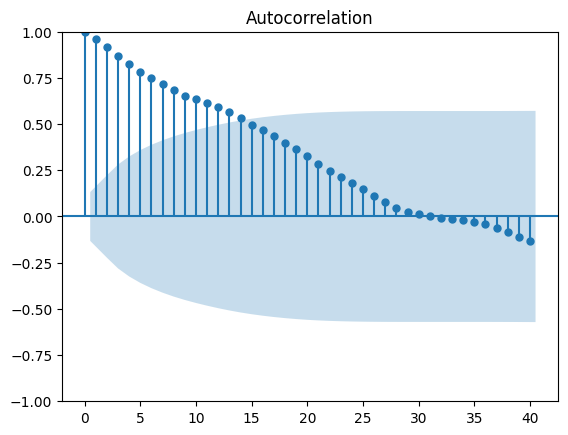

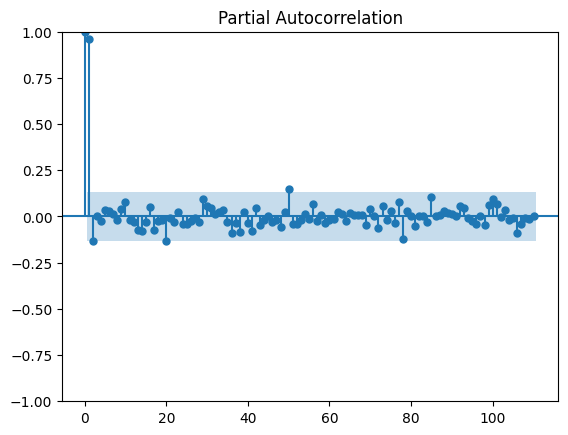

In [6]:
# Define the dependent variable and exogenous variable
y = df_combined['close_price']
x_exog = df_combined[['Normalized_Sentiment']]

print(len(y))
max_lags = len(y) // 2
print(f"The maximum number of lags allowed is: {max_lags}")
# Plot ACF and PACF for closing price data
plot_acf(y, lags=40)
plot_pacf(y, lags=max_lags)
plt.show()




In [7]:

# Fill missing values in exogenous variables by replacing them with the mean of the column
x_exog = x_exog.assign(**x_exog.fillna(x_exog.mean()))

# Assume y is the time series and x_exog are the exogenous variables
train_size = int(0.8 * len(df_combined))  # Split the data into 80% training and 20% testing
y_train = df_combined['close_price'][:train_size]
y_test = df_combined['close_price'][train_size:]
x_exog_train = df_combined[['Normalized_Sentiment']][:train_size]
x_exog_test = df_combined[['Normalized_Sentiment']][train_size:]

# Initialize the ARIMAX model (SARIMAX model in this case)
model = SARIMAX(
    y_train,
    exog=x_exog_train,
    order=(1, 1, 1),  # ARIMA order: (p, d, q)
    seasonal_order=(1, 1, 0, 5),  # Seasonal order: (P, D, Q, S)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Training the model
model_fit = model.fit(disp=False)  # Fit the model to the training data (displaying output is off)
print(model_fit.summary())  # Print the summary of the fitted model



                                     SARIMAX Results                                      
Dep. Variable:                        close_price   No. Observations:                  176
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 5)   Log Likelihood                -377.979
Date:                            Mon, 18 Nov 2024   AIC                            765.958
Time:                                    14:40:06   BIC                            781.458
Sample:                                03-27-2024   HQIC                           772.251
                                     - 09-18-2024                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Normalized_Sentiment   469.4844    200.526      2.341      0.019      76.460     862.509
ar.L1

In [8]:
# Number of forecast steps is equal to the number of days in y_test
forecast_steps = len(y_test)

# Perform the forecast
forecast = model_fit.get_forecast(steps=forecast_steps, exog=x_exog_test)

# Get forecast values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Align the time index with y_test
forecast_mean = forecast_mean.reindex(y_test.index)
forecast_ci = forecast_ci.reindex(y_test.index)

# Create a DataFrame containing forecast values and confidence intervals
forecast_df = pd.DataFrame({
    'Date': y_test.index,
    'Predicted_Close_Price': forecast_mean,
    'Actual_Close_Price': y_test.values,
    'Lower_CI': forecast_ci.iloc[:, 0],
    'Upper_CI': forecast_ci.iloc[:, 1]
})

# Write the forecast data to a CSV file
output_path = '/content/drive/MyDrive/stat_project/analysis/trainingset/forecast_arimax_price.csv'
forecast_df.to_csv(output_path, index=False)

print("Forecasted prices and actual prices have been saved to 'forecast_arimax_price.csv'.")
print(forecast_df)

# Evaluation Metrics
mae = mean_absolute_error(y_test, forecast_mean)
mse = mean_squared_error(y_test, forecast_mean)
mape = mean_absolute_percentage_error(y_test, forecast_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))

# Print evaluation results
print("\n--- Model Evaluation Metrics ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Forecasted prices and actual prices have been saved to 'forecast_arimax_price.csv'.
                 Date  Predicted_Close_Price  Actual_Close_Price    Lower_CI  \
date                                                                           
2024-09-19 2024-09-19             134.390360          135.200000  129.637683   
2024-09-20 2024-09-20             133.378949          135.300000  125.693606   
2024-09-21 2024-09-21             133.412107          134.866667  123.702831   
2024-09-22 2024-09-22             135.158065          134.433333  123.774763   
2024-09-23 2024-09-23             136.318924          134.000000  123.478344   
2024-09-24 2024-09-24             135.880848          134.500000  120.681953   
2024-09-25 2024-09-25             135.073278          134.800000  117.548171   
2024-09-26 2024-09-26             134.747097          134.300000  115.192018   
2024-09-27 2024-09-27             136.522192          134.200000  115.127266   
2024-09-28 2024-09-28             13

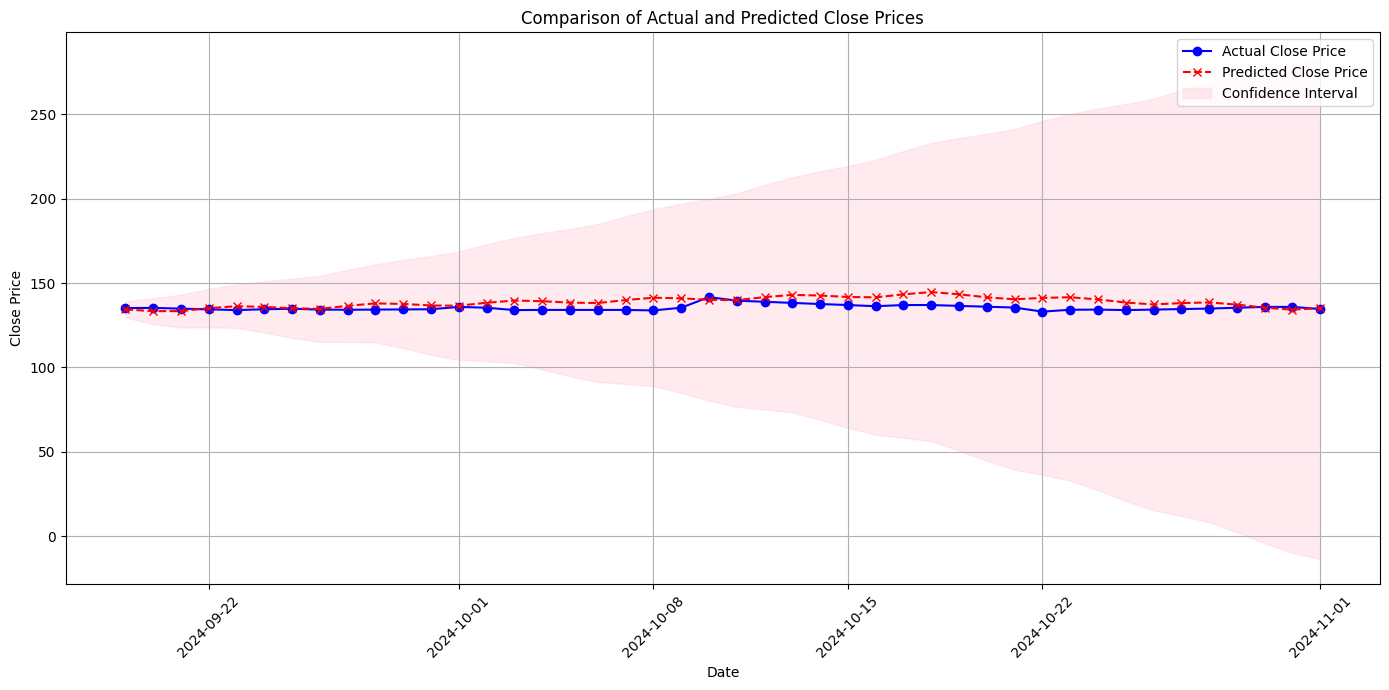

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


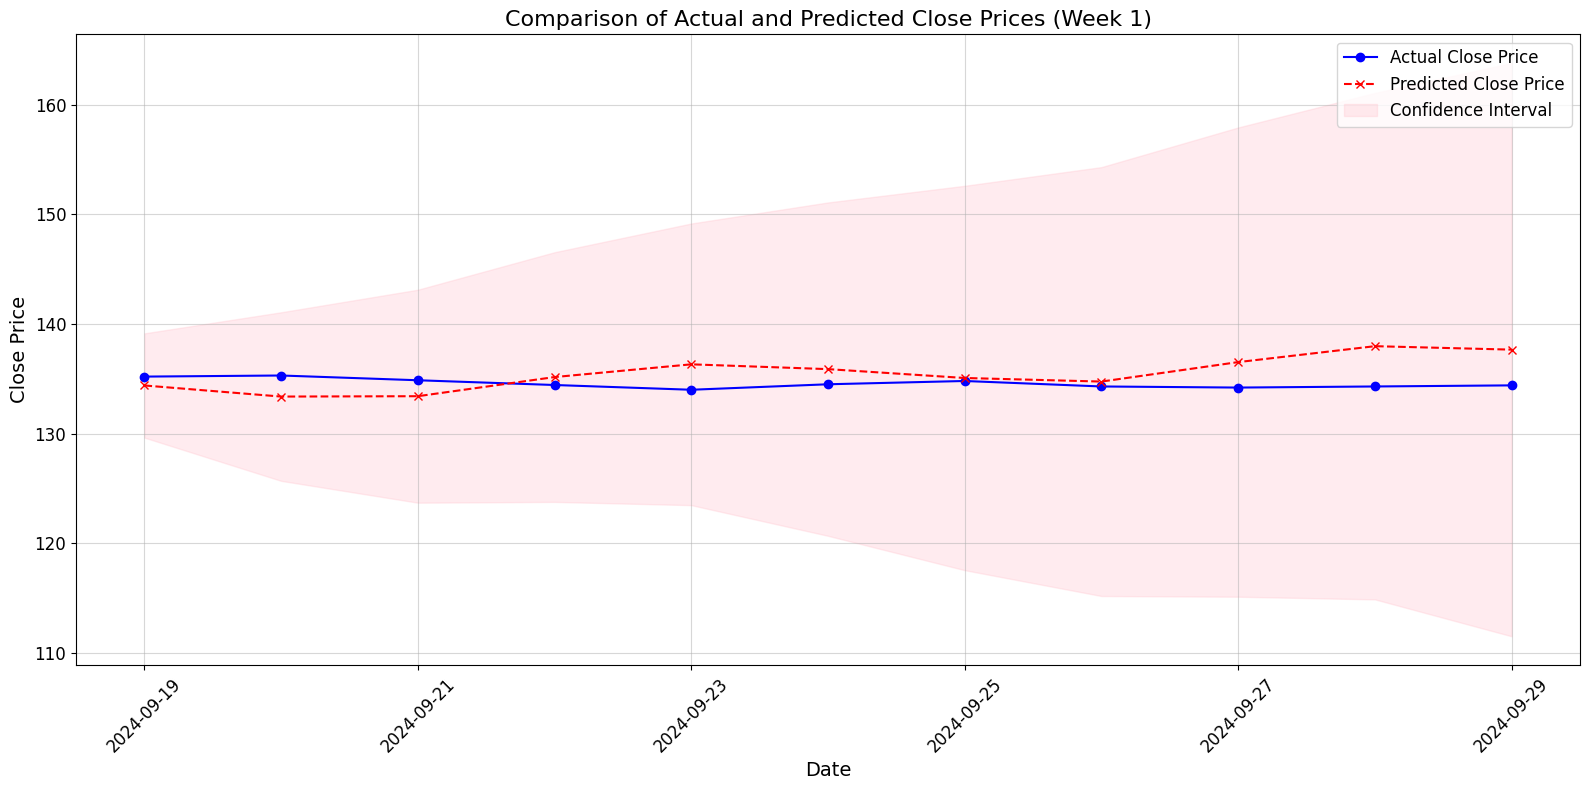

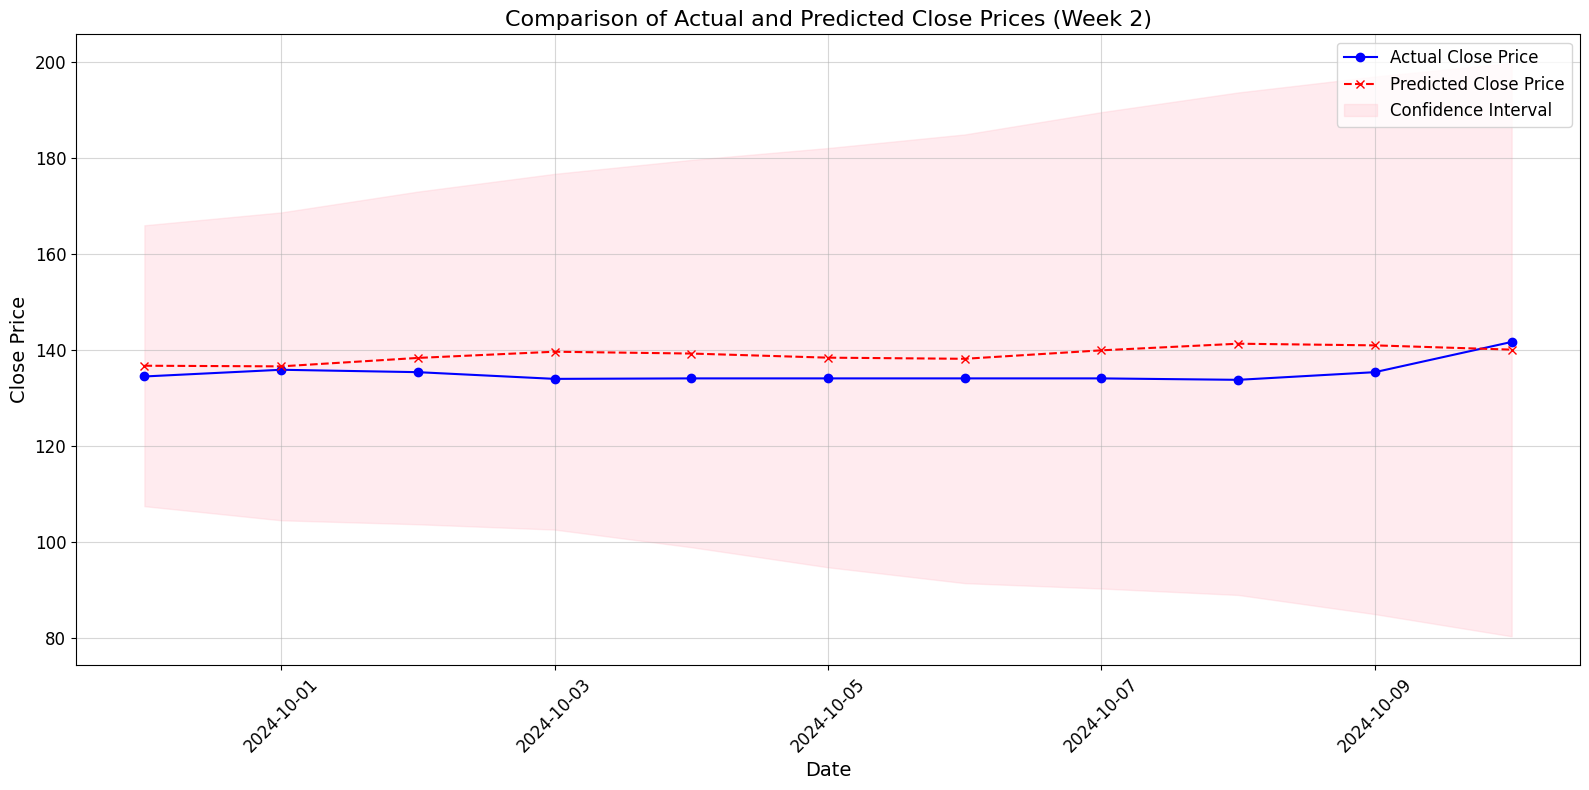

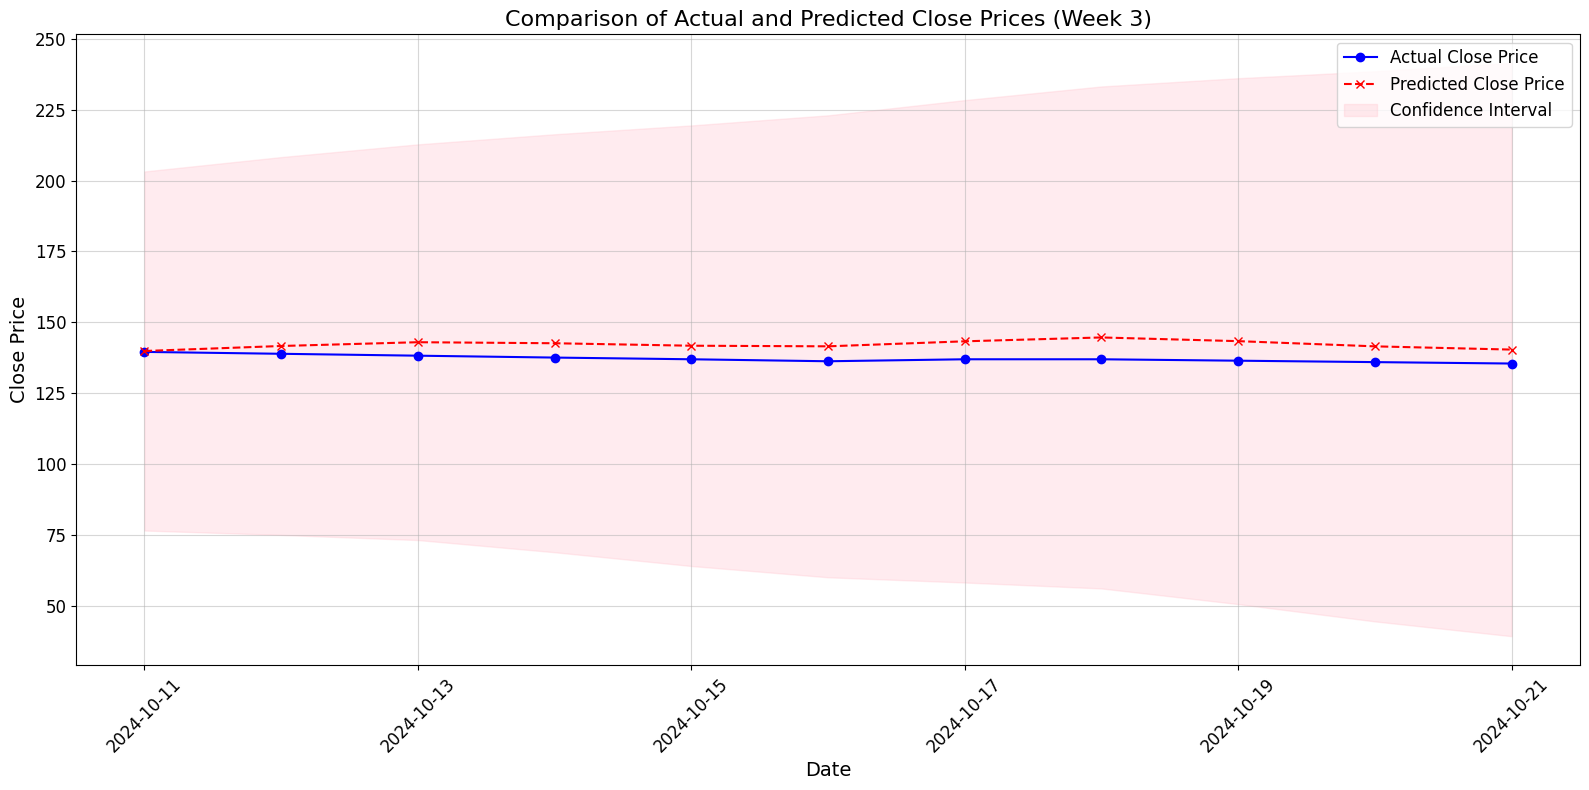

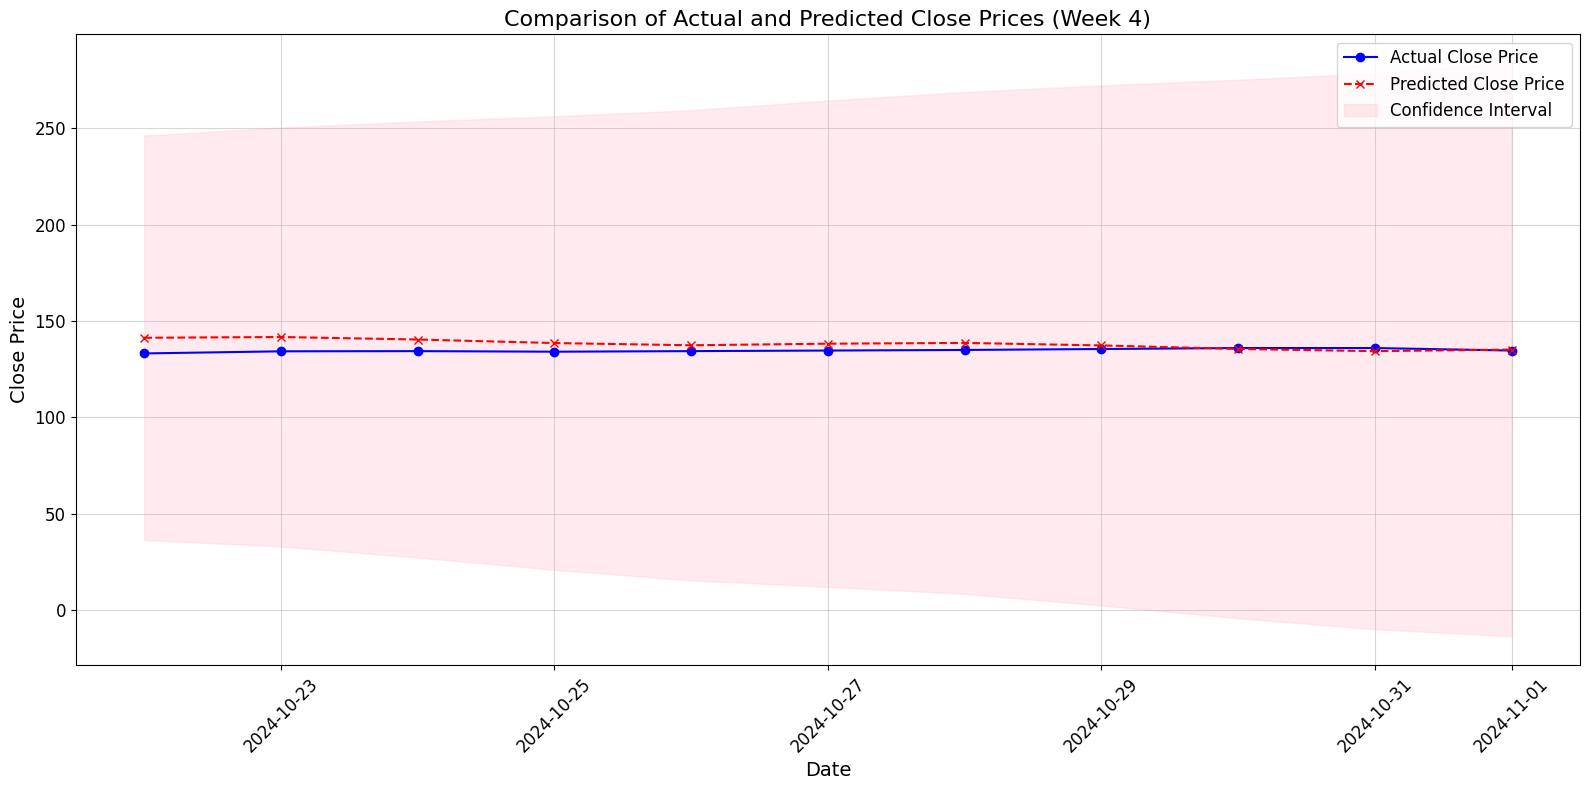

In [9]:
# Overall forecast data
# Plot comparison between predicted and actual values
plt.figure(figsize=(14, 7))
plt.plot(forecast_df['Date'], forecast_df['Actual_Close_Price'], label='Actual Close Price', color='blue', marker='o')
plt.plot(forecast_df['Date'], forecast_df['Predicted_Close_Price'], label='Predicted Close Price', color='red', linestyle='--', marker='x')

# Plot confidence interval
plt.fill_between(forecast_df['Date'], forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='pink', alpha=0.3, label='Confidence Interval')

# Set title and labels
plt.title('Comparison of Actual and Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# Split data by week
weeks = np.array_split(forecast_df, 4)  # Split the data into 4 weeks (or any number of parts you want)

for i, week in enumerate(weeks):
    plt.figure(figsize=(16, 8))
    plt.plot(week['Date'], week['Actual_Close_Price'], label='Actual Close Price', color='blue', marker='o')
    plt.plot(week['Date'], week['Predicted_Close_Price'], label='Predicted Close Price', color='red', linestyle='--', marker='x')

    # Confidence interval
    plt.fill_between(
        week['Date'],
        week['Lower_CI'],
        week['Upper_CI'],
        color='pink',
        alpha=0.3,
        label='Confidence Interval'
    )

    # Title and labels
    plt.title(f'Comparison of Actual and Predicted Close Prices (Week {i + 1})', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close Price', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Grid and legend
    plt.grid(alpha=0.5)
    plt.legend(fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()


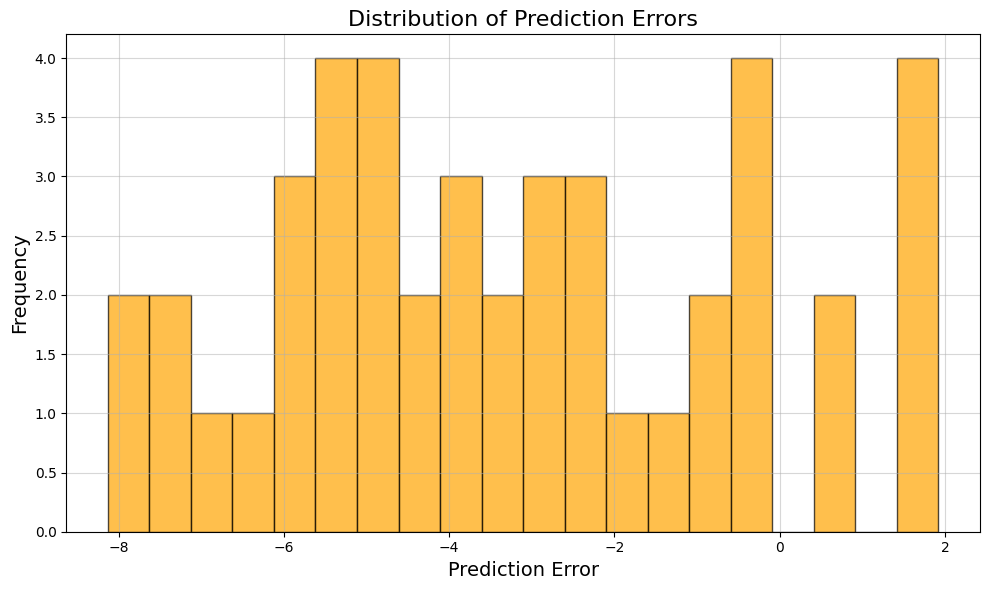

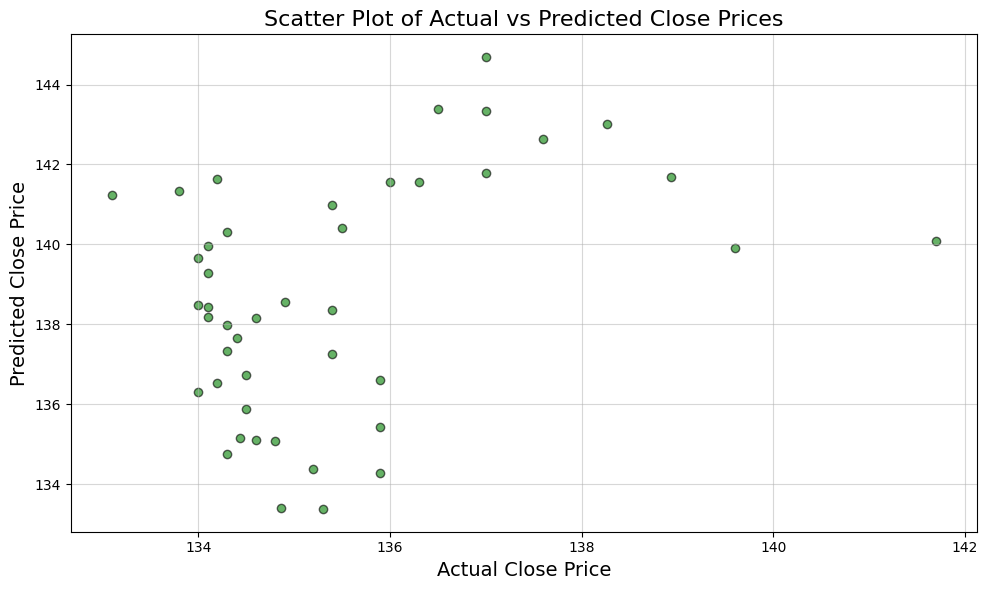

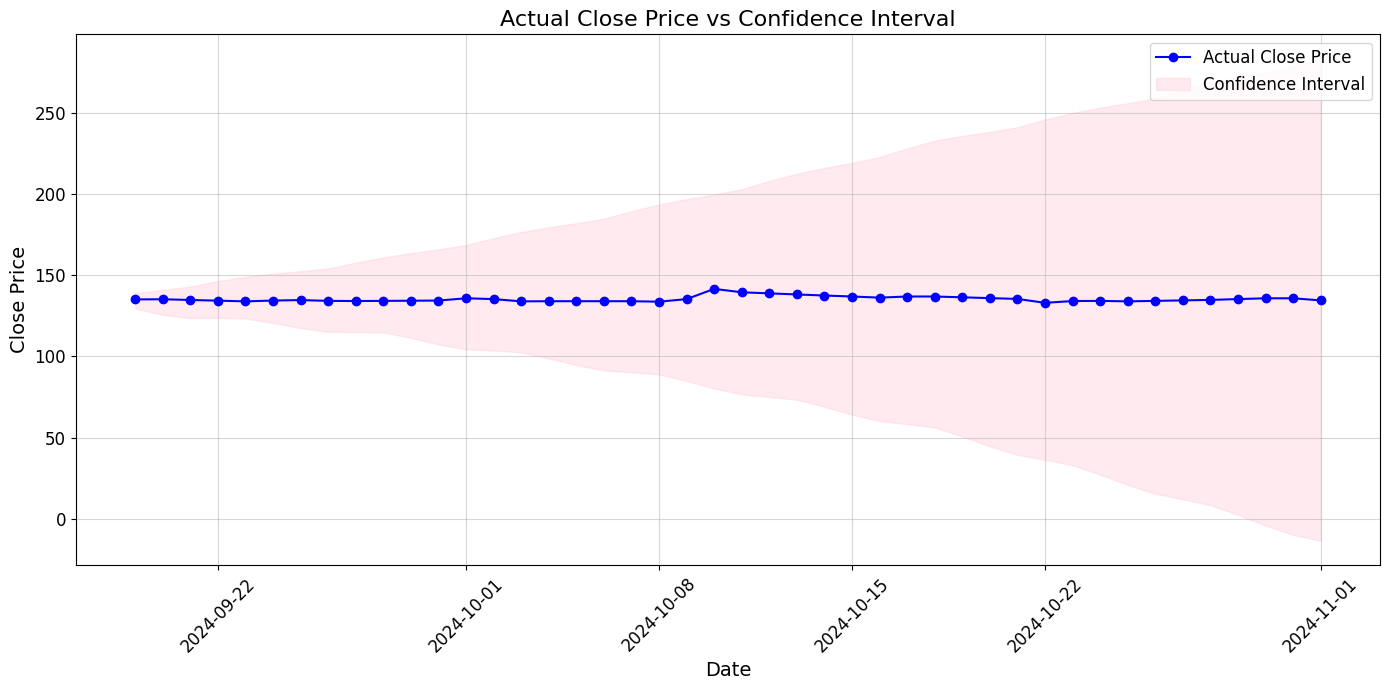

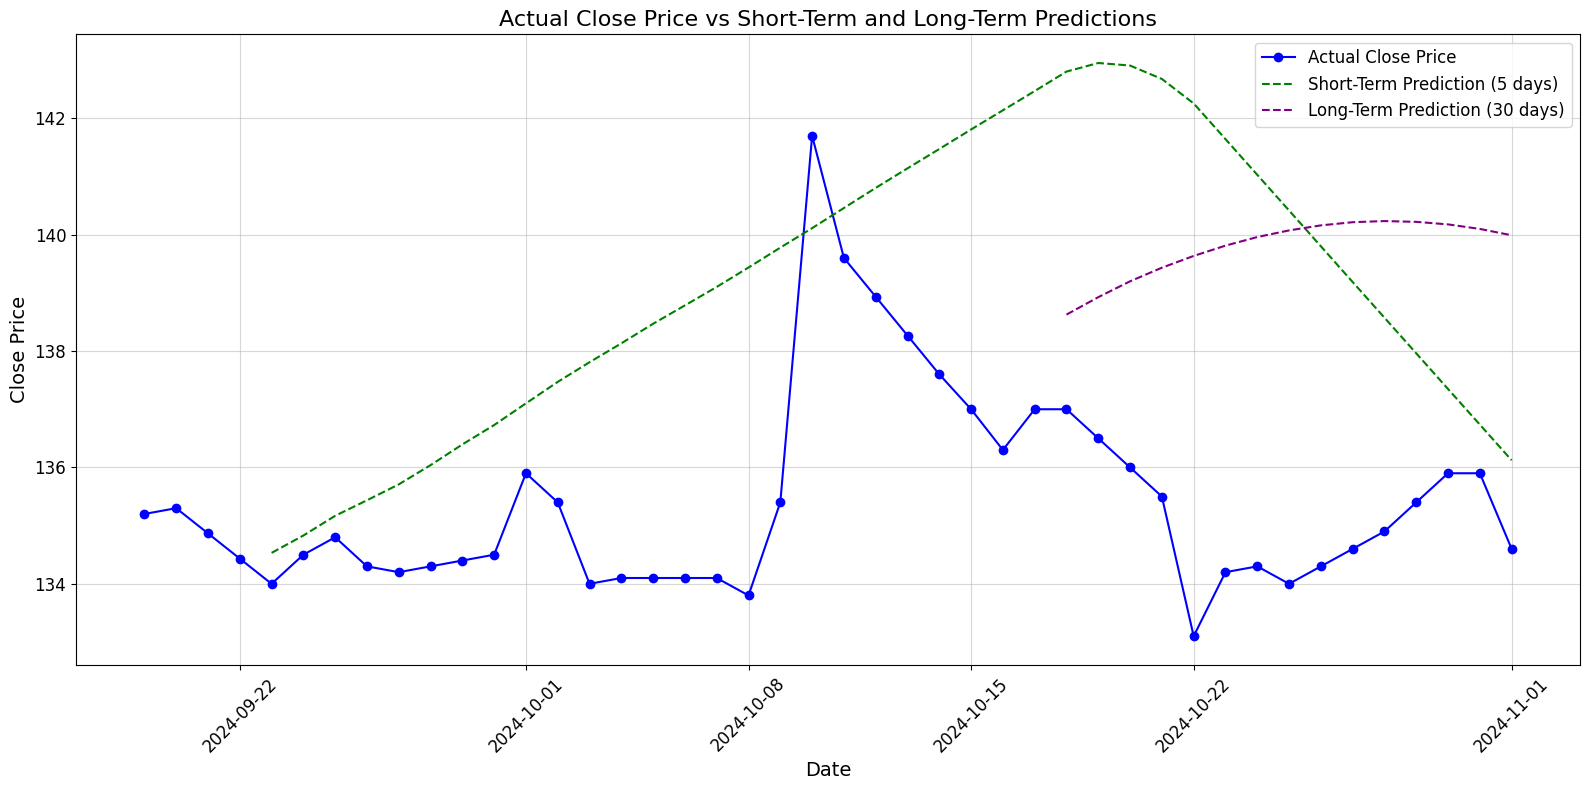

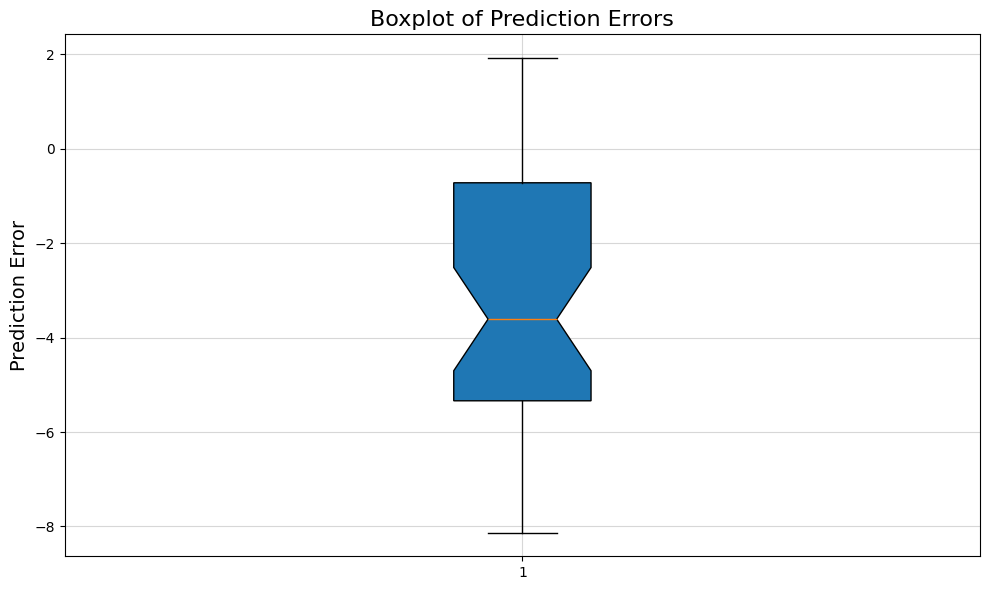

In [10]:
# 2. Histogram of Prediction Errors
# Calculate the prediction error
forecast_df['Prediction_Error'] = forecast_df['Actual_Close_Price'] - forecast_df['Predicted_Close_Price']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(forecast_df['Prediction_Error'], bins=20, color='orange', alpha=0.7, edgecolor='black')
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Scatter Plot of Actual vs Predicted Close Prices
## Purpose: Check the correlation between actual values and predicted values.
plt.figure(figsize=(10, 6))
plt.scatter(forecast_df['Actual_Close_Price'], forecast_df['Predicted_Close_Price'], color='green', alpha=0.6, edgecolor='black')
plt.title('Scatter Plot of Actual vs Predicted Close Prices', fontsize=16)
plt.xlabel('Actual Close Price', fontsize=14)
plt.ylabel('Predicted Close Price', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Actual Close Price vs Confidence Interval
## Purpose: Compare actual values with the confidence interval of the forecast.
plt.figure(figsize=(14, 7))
plt.plot(forecast_df['Date'], forecast_df['Actual_Close_Price'], label='Actual Close Price', color='blue', marker='o')

# Confidence interval
plt.fill_between(
    forecast_df['Date'],
    forecast_df['Lower_CI'],
    forecast_df['Upper_CI'],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

# Title and labels
plt.title('Actual Close Price vs Confidence Interval', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Grid and legend
plt.grid(alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# 5. Combined Plot of Short-Term and Long-Term Predictions
## Purpose: Compare actual values with short-term (5 days) and long-term (30 days) forecasts.
# Create short-term (5 days) and long-term (30 days) forecast columns
forecast_df['Short_Term_Prediction'] = forecast_df['Predicted_Close_Price'].rolling(window=5).mean()
forecast_df['Long_Term_Prediction'] = forecast_df['Predicted_Close_Price'].rolling(window=30).mean()

plt.figure(figsize=(16, 8))
plt.plot(forecast_df['Date'], forecast_df['Actual_Close_Price'], label='Actual Close Price', color='blue', marker='o')
plt.plot(forecast_df['Date'], forecast_df['Short_Term_Prediction'], label='Short-Term Prediction (5 days)', color='green', linestyle='--')
plt.plot(forecast_df['Date'], forecast_df['Long_Term_Prediction'], label='Long-Term Prediction (30 days)', color='purple', linestyle='--')

# Title and labels
plt.title('Actual Close Price vs Short-Term and Long-Term Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Grid and legend
plt.grid(alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Boxplot to compare prediction errors
## Purpose: Show the dispersion of prediction errors.
# Plot the Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(forecast_df['Prediction_Error'], patch_artist=True, notch=True)
plt.title('Boxplot of Prediction Errors', fontsize=16)
plt.ylabel('Prediction Error', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()



In [11]:
# --- Train the model on the full data ---
final_model = SARIMAX(y, exog=x_exog, order=(1, 1, 1), seasonal_order=(1, 1, 0, 5), enforce_stationarity=False, enforce_invertibility=False)
final_model_fit = final_model.fit(disp=False)

# --- Forecast for the next 60 days ---
forecast_60 = final_model_fit.get_forecast(steps=60, exog=future_sentiment)
forecast_mean_60 = forecast_60.predicted_mean
forecast_ci_60 = forecast_60.conf_int()

# Create forecast dates with the exact number of forecast values
forecast_dates = pd.date_range(start=forecast_start_date, periods=len(forecast_mean_60), freq='D')

# Create a DataFrame with the forecast results
forecast_df_60 = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted_Close_Price': forecast_mean_60.values,
    'Lower_CI': forecast_ci_60.iloc[:, 0].values,
    'Upper_CI': forecast_ci_60.iloc[:, 1].values
})

# Save the results to a CSV file
forecast_output_path = '/content/drive/MyDrive/stat_project/analysis/results/forecast_60days_arimax_price.csv'
forecast_df.to_csv(forecast_output_path, index=False)

print(f"The 60-day forecast has been saved to: {forecast_output_path}")




The 60-day forecast has been saved to: /content/drive/MyDrive/stat_project/analysis/results/forecast_60days_arimax_price.csv
